# pip

In [1]:
!pip install --upgrade camel-tools
!camel_data -i light

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.5/124.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install wordcloud matplotlib arabic-reshaper python-bidi
#!pip install arabic-reshaper python-bidi wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.6/286.6 kB 5.4 MB/s eta 0:00:00


# Prepare Libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import arabic_reshaper
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from camel_tools.disambig.mle import MLEDisambiguator
from camel_tools.tokenizers.word import simple_word_tokenize
from camel_tools.tokenizers.morphological import MorphologicalTokenizer

# Load Dataset

In [7]:
train = '/content/drive/MyDrive/ADQD/train.csv'
test = '/content/drive/MyDrive/ADQD/test.csv'

In [8]:
train_df = pd.read_csv(train)
test_df = pd.read_csv(test)

# Prepar Data

In [9]:
train_df.shape

(11997, 3)

In [10]:
train_df.head()

,question1,question2,label
0,ما هي الطرق الصحيحة للاعتناء بالحامل؟,كيف اهتم بطفلي؟,0
1,ما هي وسائل الاتصالات الحديثة؟,ماذا نعني بوسائل الاتصال الحديثة؟,1
2,ما طريقة تحضير محشي الكوسا ؟,من طرق تحضير محشي الكوسا؟,1
3,ما طريقة تحضير حلى الطبقات؟,من طرق تحضير طبقات الكيك؟,0
4,من الآيات القرآنية عن الراعي والرعية ؟,ما هو تعريف الراعي والرعية ؟,0


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11997 entries, 0 to 11996
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   question1  11997 non-null  object
 1   question2  11997 non-null  object
 2   label      11997 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 281.3+ KB


In [12]:
train_df.isnull().sum()

,0
question1,0
question2,0
label,0


In [13]:
test_df.isnull().sum()

,0
question1,0
question2,0
QuestionPairID,0


In [14]:
train_df.duplicated().sum()

0

In [15]:
test_df.duplicated().sum()

0

# EDA

## Distribution of Labels

In [16]:
# Distribution of duplicate and non-duplicate questions
train_df['label'].value_counts()

,count
label,
0,6600
1,5397


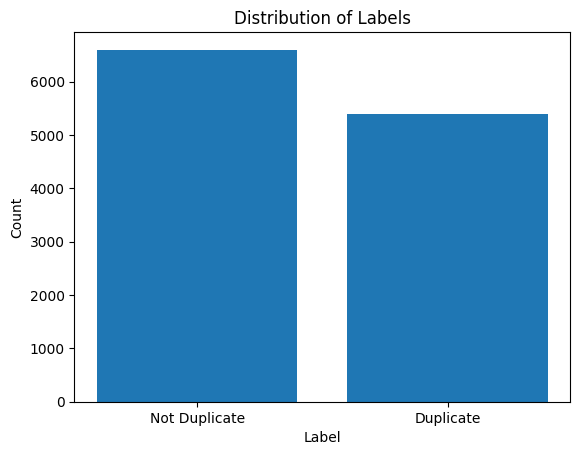

In [17]:
label_counts = train_df['label'].value_counts()
label_0_count = label_counts.get(0, 0)
label_1_count = label_counts.get(1, 0)

plt.bar(['Not Duplicate', 'Duplicate'], [label_0_count, label_1_count])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

<div dir='rtl'>
نلاحظ ان الداتا متوازنة
</div>

## Tokenization

<div dir='rtl'>
الدالة tokenize تستقبل نصًا كدخل وتقوم بتقطيعه من خلال عدة خطوات
</div>

<div dir='rtl'>
mle_msa: يتم تحميل معالج مخصص لفك التباس الكلمات باستخدام نموذج Maximum Likelihood Estimation (MLE) للغة العربية الفصحى (MSA).
msa_bw_tokenizer: يتم إعداد MorphologicalTokenizer مع المعالج mle_msa واختيار نظام فك التقطيع atbtok الذي يتعامل مع التقطيع بناءً على الشكل الصرفي للكلمات.
</div>

In [18]:
punctuationPattern = r"([*|,\-#!<&>_+{:/$\\=()?؟.،'}%\";\[\]])"

# Initialize disambiguators
mle_msa = MLEDisambiguator.pretrained('calima-msa-r13')
msa_bw_tokenizer = MorphologicalTokenizer(disambiguator=mle_msa, scheme='atbtok')

def tokenize(text):
    tokens = msa_bw_tokenizer.tokenize([token for sent in re.split(punctuationPattern,
                                                      text.strip()) for token in sent.split()])
    for i, token in enumerate(tokens):
        if token.startswith(('ب', 'ف', 'ل')):
            subtokens = token.split('+_')
            if len(subtokens) > 1:
                tokens[i] = subtokens[0]
                tokens.insert(i + 1, subtokens[1])
        elif token == 'من_+ما':
            tokens[i] = 'مما'
        else:
            tokens[i] = re.sub(r'\+_|_\+', '', token)
    return tokens

In [19]:
train_df['tokenized_question1'] = train_df['question1'].apply(lambda x: tokenize(str(x)))
train_df['tokenized_question1'].head()

,tokenized_question1
0,"[ما, هي, الطرق, الصحيحة, ل, الاعتناء, ب, الحام..."
1,"[ما, هي, وسائل, الاتصالات, الحديثة, ؟]"
2,"[ما, طريقة, تحضير, محشي, الكوسا, ؟]"
3,"[ما, طريقة, تحضير, حليي, الطبقات, ؟]"
4,"[من, الآيات, القرآنية, عن, الراعي, والرعية, ؟]"


In [20]:
train_df['tokenized_question2'] = train_df['question2'].apply(lambda x: tokenize(str(x)))
train_df['tokenized_question2'].head()

,tokenized_question2
0,"[كيف, اهتم, ب, طفليي, ؟]"
1,"[ماذا, نعني, ب, وسائل, الاتصال, الحديثة, ؟]"
2,"[من, طرق, تحضير, محشي, الكوسا, ؟]"
3,"[من, طرق, تحضير, طبقات, الكيك, ؟]"
4,"[ما, هو, تعريف, الراعي, والرعية, ؟]"


## Distribution of Question Lengths

<div dir='rtl'>
تحليل طول الأسئلة في كل من العمودين (question1 و question2).
</div>

In [21]:
train_df['q1_length'] = train_df['tokenized_question1'].apply(lambda x: len(str(x)))
train_df['q2_length'] = train_df['tokenized_question2'].apply(lambda x: len(str(x)))

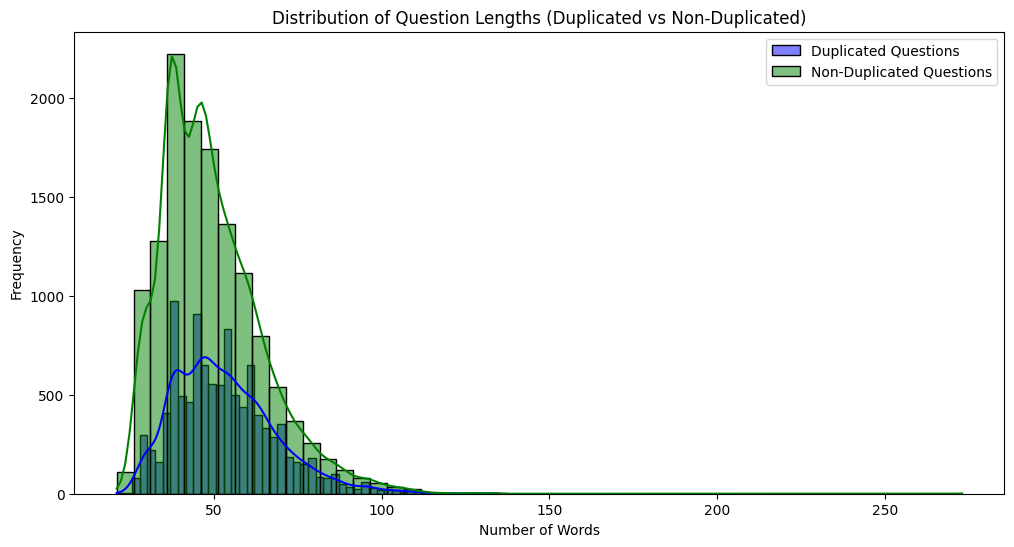

In [22]:
# دمج أطوال الأسئلة في عمود واحد مع الحفاظ على تصنيف "label"
lengths_data = train_df.melt(id_vars='label', value_vars=['q1_length', 'q2_length'],
                         var_name='question_type', value_name='question_length')

# فصل البيانات إلى مكررة وغير مكررة
duplicated_lengths = lengths_data[lengths_data['label'] == 1]['question_length']
non_duplicated_lengths = lengths_data[lengths_data['label'] == 0]['question_length']

# رسم التوزيع
plt.figure(figsize=(12, 6))

# توزيع الأسئلة المكررة
sns.histplot(duplicated_lengths, color='blue', kde=True, label='Duplicated Questions', bins=50)

# توزيع الأسئلة غير المكررة
sns.histplot(non_duplicated_lengths, color='green', kde=True, label='Non-Duplicated Questions', bins=50)

# إضافة التفاصيل إلى الرسم
plt.legend()
plt.title('Distribution of Question Lengths (Duplicated vs Non-Duplicated)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [23]:
train_df['duplicated_lengths'] = lengths_data[lengths_data['label'] == 1]['question_length']
train_df['non_duplicated_lengths'] = lengths_data[lengths_data['label'] == 0]['question_length']
train_df[['duplicated_lengths', 'non_duplicated_lengths']].describe()

,duplicated_lengths,non_duplicated_lengths
count,5397.000000,6600.000000
mean,52.762831,53.159848
std,15.235296,15.589747
min,21.000000,25.000000
25%,41.000000,41.000000
50%,51.000000,51.000000
75%,62.000000,62.000000
max,130.000000,134.000000


<div dir='rtl'>
نلاحظ من الرسم التالي:

*   يشير الشكل العام للمنحنى إلى أن توزيع أطوال الأسئلة يتبع نمطاً طبيعياً
*   يبدو أن الأسئلة المكررة تميل إلى أن تكون أقصر من الأسئلة غير المكررة. هذا يمكن أن يكون بسبب أن الأسئلة البسيطة والمباشرة قد تتكرر أكثر من الأسئلة المعقدة والطويلة.
</div>

## Length Difference

<ipython-input-24-58e71fbe05fc>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='label', y='length_diff', data=train_df, palette='muted', scale='width')
<ipython-input-24-58e71fbe05fc>:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='label', y='length_diff', data=train_df, palette='muted', scale='width')


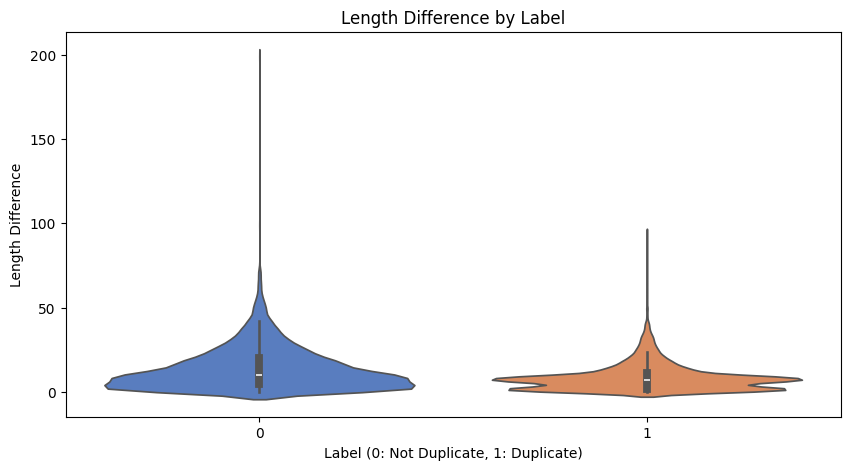

In [24]:
# حساب الفرق في الطول
train_df['length_diff'] = abs(train_df['q1_length'] - train_df['q2_length'])

# رسم التوزيع باستخدام Violin Plot
plt.figure(figsize=(10, 5))
sns.violinplot(x='label', y='length_diff', data=train_df, palette='muted', scale='width')
plt.title('Length Difference by Label')
plt.xlabel('Label (0: Not Duplicate, 1: Duplicate)')
plt.ylabel('Length Difference')
plt.show()


<div dir='rtl'>
نلاحظ من الرسم التالي:

*  اختلاف كبير في فرق الطول: يظهر الرسم البياني وجود اختلاف كبير في فرق الطول بين المجموعتين.
*   توزيع غير متماثل: توزيع فرق الطول في كلا المجموعتين غير متماثل، حيث يمتد ذيل التوزيع إلى قيم أعلى بشكل أكبر من ذيله السفلي. هذا يشير إلى وجود بعض القيم المتطرفة (outliers) في كلا المجموعتين.
</div>
<div dir='rtl'>
وبالتالي يمكن تقديم التفسير التالي:


*  يمكن أخذ فرق الطول كمعيار لقياس مدى تشابه أو اختلاف الاسئلة، فالقيم المنخفضة لفرق الطول تشير إلى أن الاسئلة متشابهة إلى حد كبير، بينما القيم المرتفعة تشير إلى اختلاف كبير.
</div>

## Similarity Analysis

In [25]:
def common_word_ratio(q1, q2):
    q1_words = set(q1)
    q2_words = set(q2)
    return len(q1_words & q2_words) / (len(q1_words | q2_words) + 1e-6)


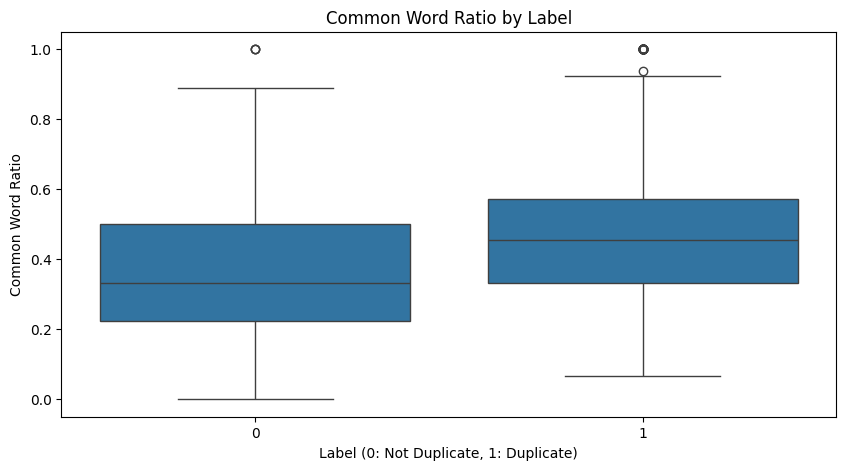

In [26]:
train_df['common_ratio'] = train_df.apply(lambda row: common_word_ratio(row['tokenized_question1'], row['tokenized_question2']), axis=1)

plt.figure(figsize=(10, 5))
sns.boxplot(x='label', y='common_ratio', data=train_df)
plt.title('Common Word Ratio by Label')
plt.xlabel('Label (0: Not Duplicate, 1: Duplicate)')
plt.ylabel('Common Word Ratio')
plt.show()


<div dir='rtl'>
نلاحظ من الرسم التالي:

*  الأسئلة المكررة تتشارك في عدد أكبر من الكلمات حيث أن نسبة الكلمات المشتركة بين الأسئلة المكررة أعلى بكثير مقارنة بالأسئلة غير المكررة، هذا يعني أن الأسئلة المكررة تتشارك في عدد كبير من الكلمات، مما يدل على تشابه كبير في المحتوى بينها.
*  توزيع واسع لنسبة الكلمات المشتركة في الأسئلة غير المكررة حيث تظهر مجموعة الأسئلة غير المكررة توزيعًا أوسع لنسبة الكلمات المشتركة، مما يشير إلى تنوع أكبر في درجة التشابه بين هذه الأسئلة. قد يكون هناك بعض الأزواج من الأسئلة غير المكررة التي تتشارك في عدد كبير من الكلمات، بينما قد تكون أزواج أخرى لا تتشارك في أي كلمات.

*   وجود قيم متطرفة: يظهر وجود بعض القيم المتطرفة (outliers) في كلا المجموعتين، خاصة في مجموعة الأسئلة غير المكررة. هذه القيم المتطرفة تمثل الأزواج من الأسئلة التي لها نسبة تشابه غير متوقعة، إما عالية جدًا أو منخفضة جدًا.
</div>
<div dir='rtl'>
وبالتالي يمكن تقديم التفسير التالي:


*   من المحتمل أن يكون حساب نسبة الكلمات المشتركة هو المعيار الأساسي المستخدم لتحديد ما إذا كان سؤالان مكرران أم لا. إذا كانت نسبة الكلمات المشتركة تتجاوز عتبة معينة، يتم تصنيف السؤالين على أنهما مكرران.
</div>

##  Word Cloud

In [27]:
train_df['combined_questions'] = train_df['tokenized_question1'] +  train_df['tokenized_question2']

train_df['combined_questions'].head()

,combined_questions
0,"[ما, هي, الطرق, الصحيحة, ل, الاعتناء, ب, الحام..."
1,"[ما, هي, وسائل, الاتصالات, الحديثة, ؟, ماذا, ن..."
2,"[ما, طريقة, تحضير, محشي, الكوسا, ؟, من, طرق, ت..."
3,"[ما, طريقة, تحضير, حليي, الطبقات, ؟, من, طرق, ..."
4,"[من, الآيات, القرآنية, عن, الراعي, والرعية, ؟,..."


In [28]:
def column_to_wordcloud(df, column, stopwords):

    all_words = ' '.join([' '.join(tokens) for tokens in df[column]])

    text = arabic_reshaper.reshape(all_words)
    # create and display the wordcloud
    wordcloud = WordCloud(font_path='/content/drive/My Drive/noto-naskh-arabic/static/NotoNaskhArabic-Regular.ttf',
                          width=3500, height=2000, random_state=1, background_color='white',
                          colormap='viridis_r', collocations=False,
                          stopwords = stopwords).generate(text)

    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

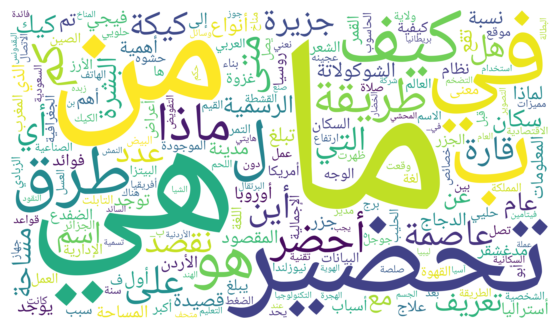

In [29]:
column_to_wordcloud(train_df, 'combined_questions', [])

In [30]:
path = '/content/drive/My Drive/FINAL_DATASET/arabic_dialects_stopwords.csv'
stopwords = pd.read_csv(path)["word"].tolist()
stopwords = [arabic_reshaper.reshape(s) for s in stopwords]
print(len(stopwords))

1997


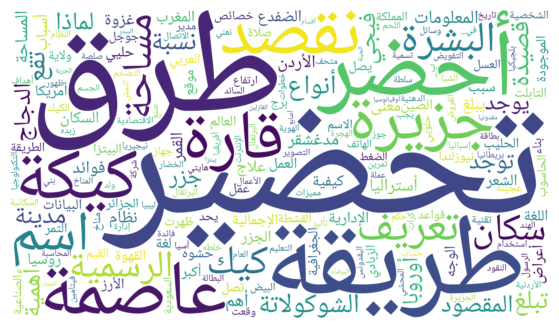

In [31]:
column_to_wordcloud(train_df, 'combined_questions', stopwords)

<div dir='rtl'>
بعد إزالة كلمات التوقف لتوضيح الكلمات بشكل أفضل.
</div>
<div dir='rtl'>
نلاحظ وجود تشابه بين أكثر الكلمات تكرار، مثال:


*   تحضير، احضر
*   طرق، طريقة، الطريقة
*   كيك، كيكة
</div>

# Feature engineer

<div dir='rtl'>
سأقوم باستخدام الميزات المستخرجة من عمليات التحليل، وهي:


*   length_diff فرق الطول في الاسئلة
*   common_ratio نسبة الكلمات المشتركة


</div>

In [36]:
X = train_df[['length_diff', 'common_ratio']]
y = train_df['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

<div dir='rtl'>
بداية سأقوم باختبار النموذج على البيانات الخام
</div>

In [38]:
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [39]:
logreg = LogisticRegression(random_state=42, max_iter=1000)

logreg.fit(X_train, y_train)
y_test_pred = logreg.predict(X_test)

In [40]:
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy:.6f}")

Accuracy: 0.610417


In [41]:
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.70      0.66      1285
           1       0.59      0.51      0.55      1115

    accuracy                           0.61      2400
   macro avg       0.61      0.60      0.60      2400
weighted avg       0.61      0.61      0.61      2400



In [42]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))


Confusion Matrix:
[[898 387]
 [548 567]]
